## Overview

This company develops innovative Artificial Intelligence and Computer Vision solutions that revolutionize industries. One such product is a new mobile document digitization experience for the blind, for researchers and for everyone else in need for fully automatic, highly fast and high-quality document scanning in bulk. It is composed of a mobile app and all the user needs to do is flip pages. The product...

1. detects page flips from a low-resolution camera preview,
2. takes a high-resolution picture of the document, 
3. recognizes its corners and crops it accordingly, 
4. dewarps the cropped document to obtain a bird's eye view, 
5. sharpens the contrast between the text and the background,
6. finally recognizes the text with formatting kept intact, being further corrected by the company's ML-powered redactor.


**Data:**

Page flipping video was collected from smart phones. Videos have been clipped, as well as labeled ('flipping' and 'not flipping'). The extracted frames were saved to disk in a sequential order with the following naming structure: VideoID_FrameNumber.

**Goal:**  

*Predict if the page is being flipped using a single image.* 

(Evaluate model performance based on F1 score.)

**Bonus:**

*Predict if a given sequence of images contains an action of flipping.*

In [1]:
from platform import python_version

import numpy as np
import pandas as pd
import json
import os
import shutil
from datetime import datetime
from PIL import Image
import collections
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

import tensorflow as tf
from tensorflow import keras
# from keras.utils.vis_utils import plot_model
from keras.models import Model
from keras.layers import Input, BatchNormalization, ReLU, LeakyReLU, Dense, Flatten, Dropout, MaxPool2D
from keras.layers import GlobalAveragePooling2D, TimeDistributed, GRU
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.merge import concatenate
from keras.preprocessing.image import ImageDataGenerator, image_dataset_from_directory
from tensorboard.plugins.hparams import api as hp

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.express as px
import plotly.offline as pyo
pyo.init_notebook_mode()

from scipy.special import softmax
from scipy.special import expit as sigmoid
from scipy.special import logit

In [2]:
print('Python:', python_version(), '\nTensorflow:', tf.__version__, '\nKeras:', keras.__version__)

Python: 3.8.5 
Tensorflow: 2.6.0 
Keras: 2.6.0


In [3]:
# For reproducible randomness
ranseed = 99
np.random.seed(ranseed)
tf.random.set_seed(ranseed)

In [4]:
# paths
TRAIN_DIR = 'images/training/'
VAL_DIR = 'images/valid/'
TEST_DIR = 'images/testing/'

Image size: (1080, 1920)


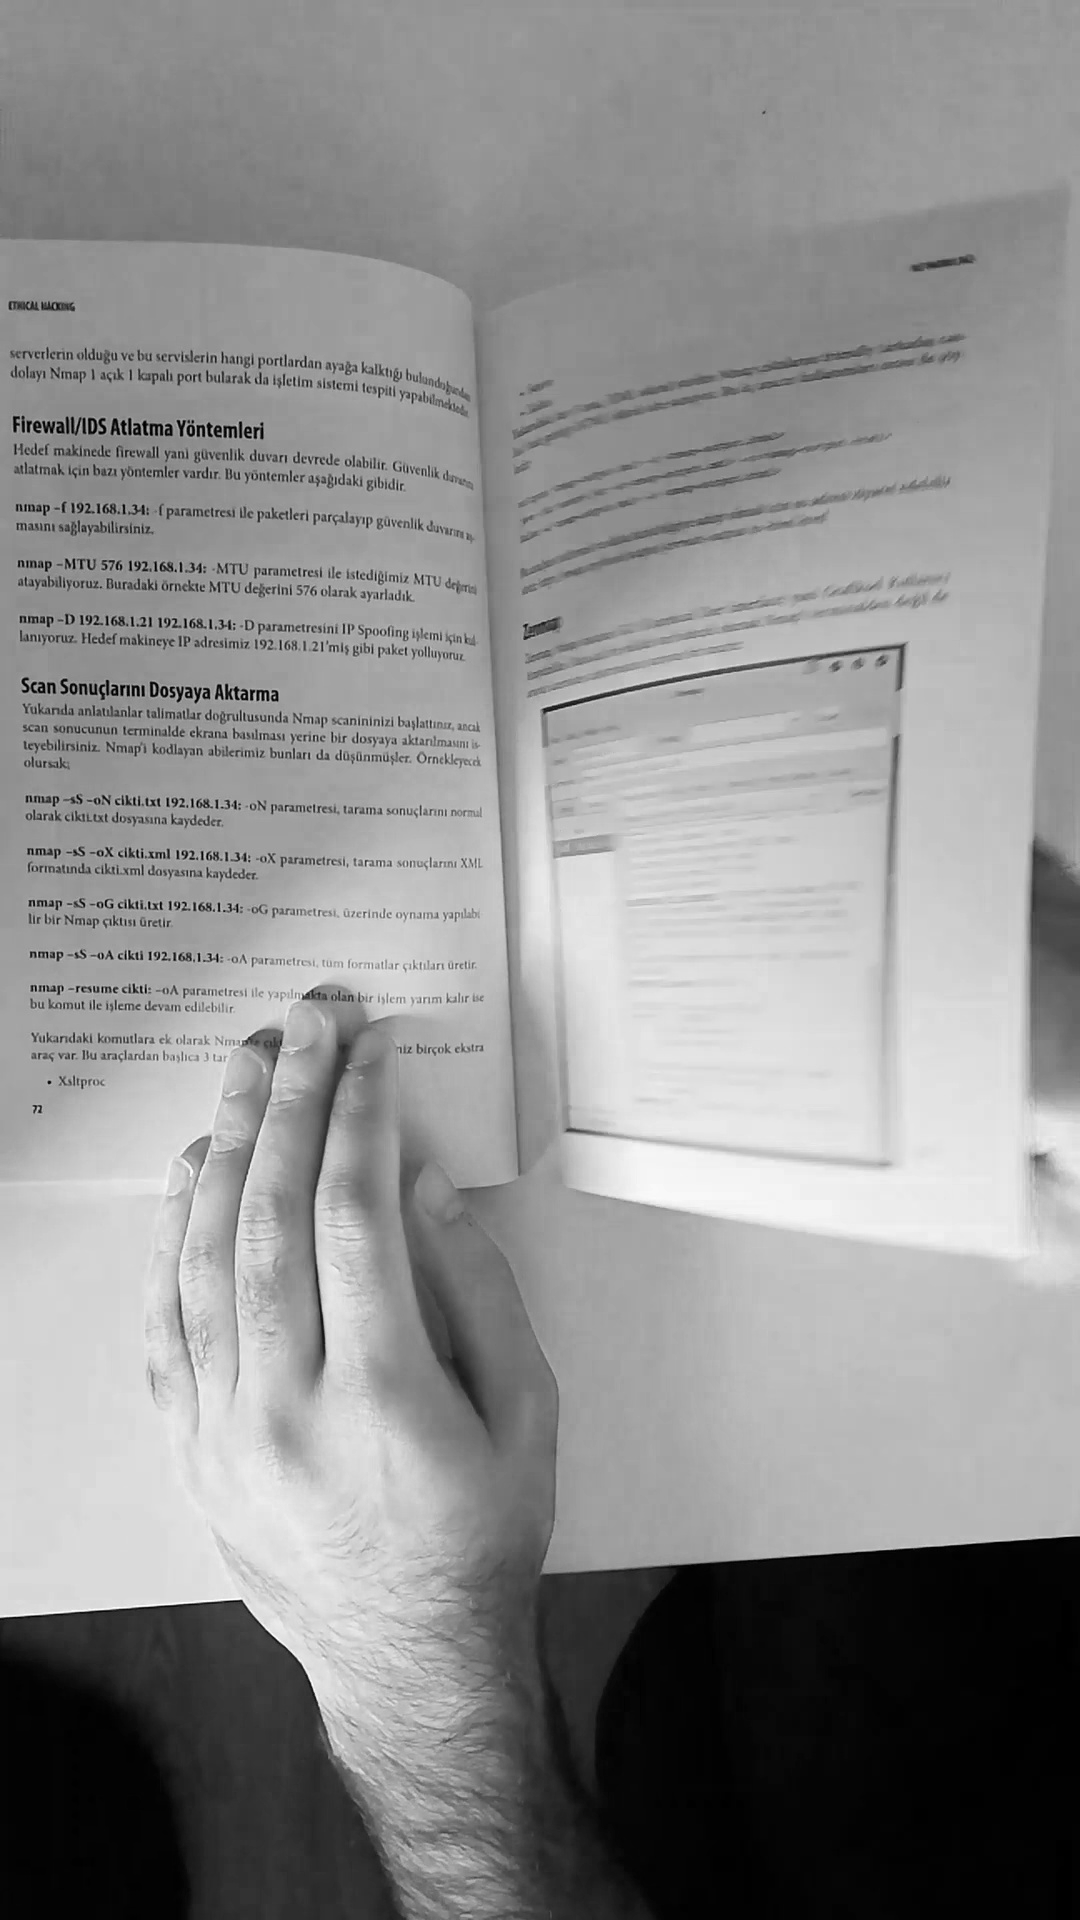

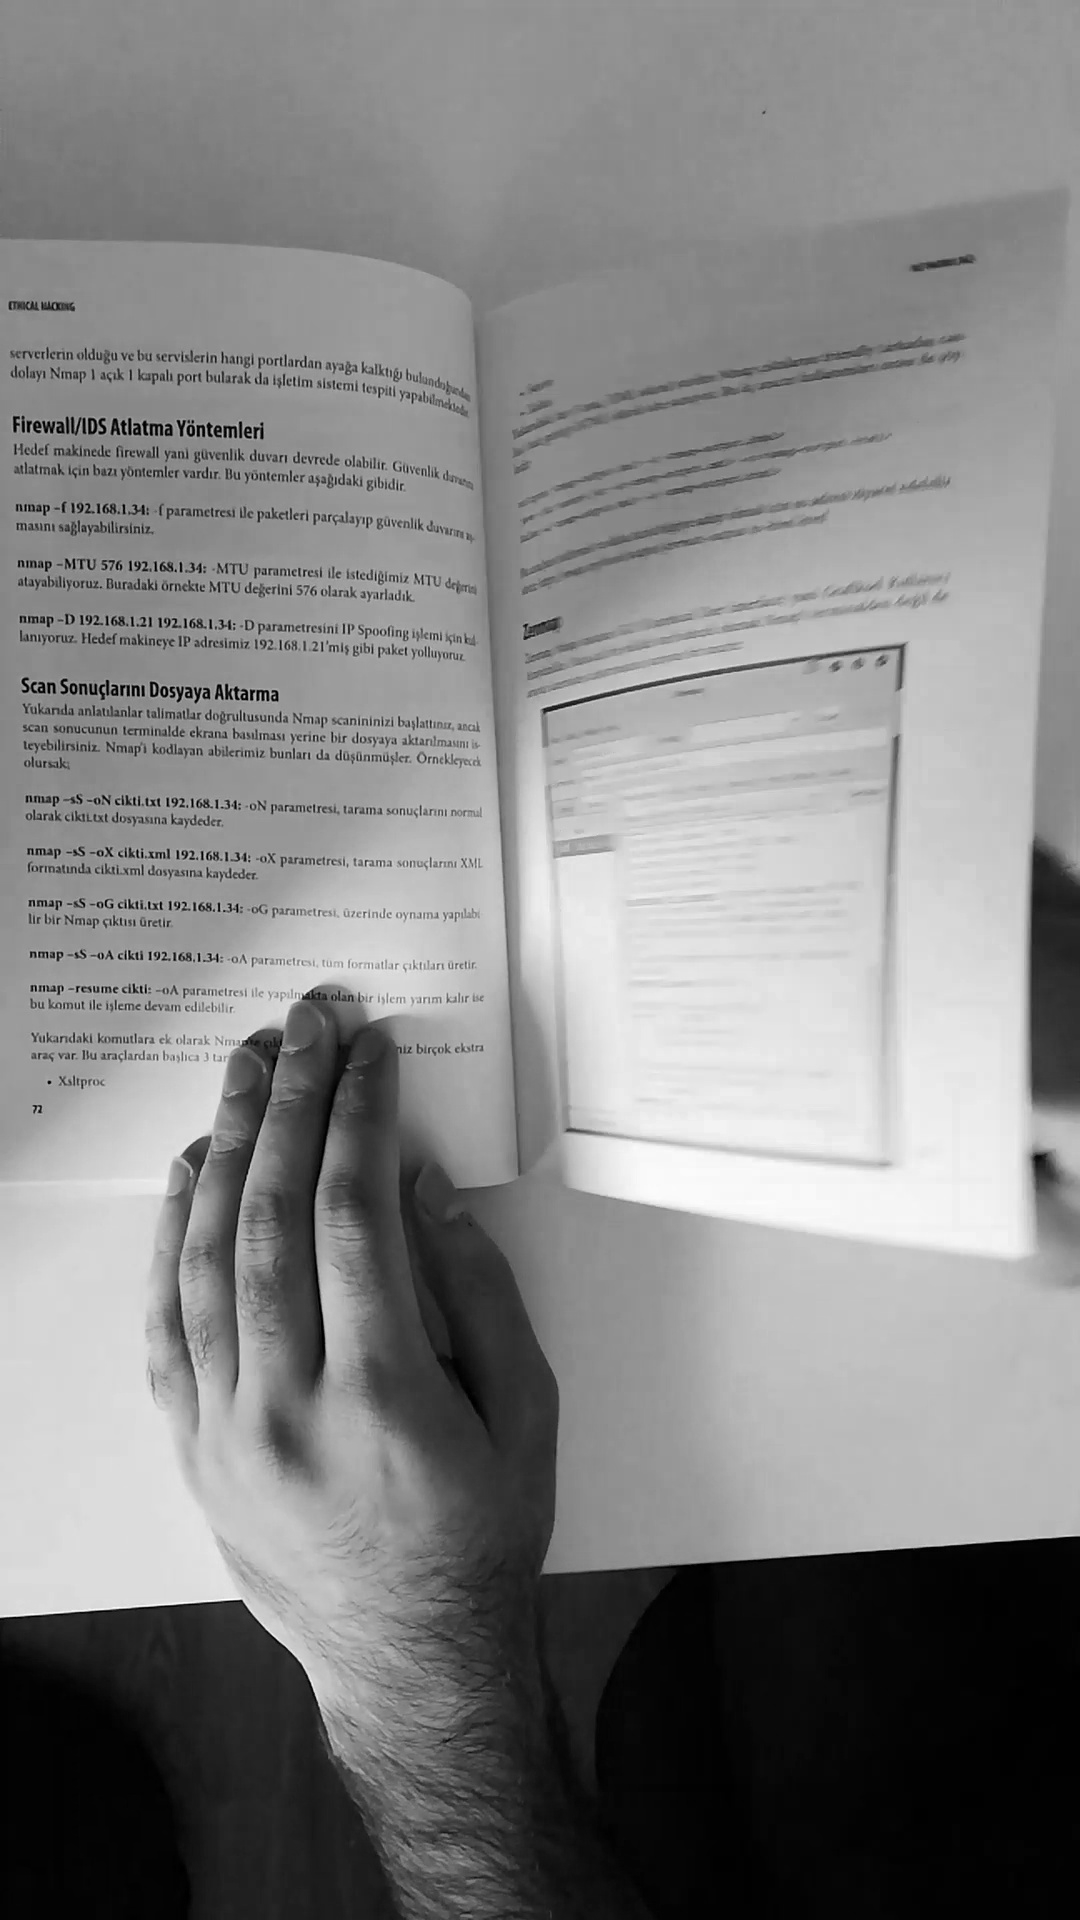

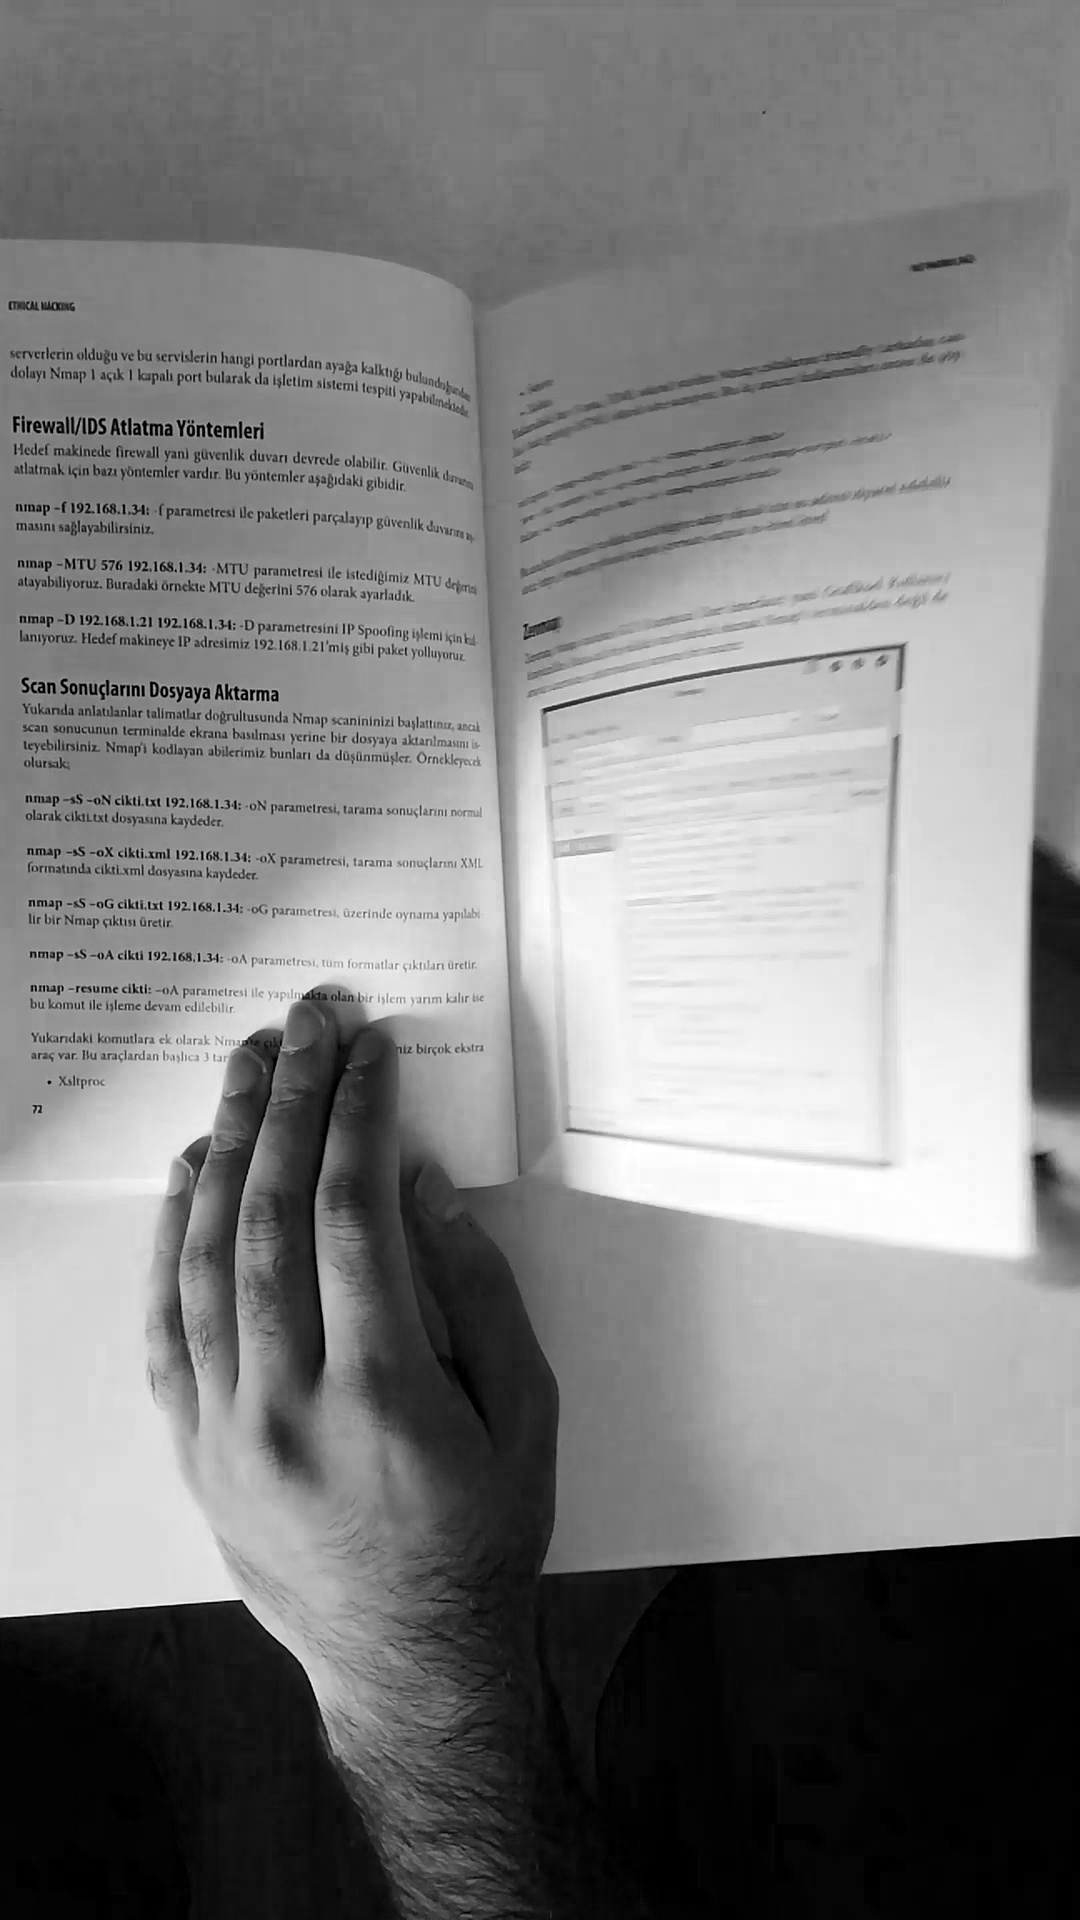

In [5]:
with Image.open(TRAIN_DIR + 'flip/0001_000000010.jpg') as im:
    # display(im)
    print('Image size:', im.size)
    r, g, b = im.split()
    display(r)
    display(g)
    display(b)

In [6]:
print('Width divided by 4 =', im.size[0] // 4)
print('Height divided by 4 =', im.size[1] // 4)

Width divided by 4 = 270
Height divided by 4 = 480


train-validation split

In [7]:
# read names of training files

my_flips = []
for file in os.listdir(TRAIN_DIR + 'flip/'):
    if file.endswith('.jpg'):
        my_flips.append('flip/' + file)
        
my_notflips = []
for file in os.listdir(TRAIN_DIR + 'notflip/'):
    if file.endswith('.jpg'):
        my_notflips.append('notflip/' + file)

In [8]:
len(my_flips)

940

In [9]:
len(my_notflips)

990

### I will create a validation set for tracking metrics during neural net training

In [10]:
# random subset (1/6th) of training files for validation set

valid_flips = list(np.random.choice(np.array(my_flips), len(my_flips) // 6, replace=False))
valid_notflips = list(np.random.choice(np.array(my_notflips), len(my_notflips) // 6, replace=False))
valid = valid_flips + valid_notflips


# append path to validation set list

from_train = [TRAIN_DIR + s for s in valid]
to_val = [VAL_DIR + s for s in valid]

In [11]:
# (ONLY RUN THIS CELL ONCE!)

# move some files in training set to validation set

# for f, fnew in zip(from_train, to_val):
#     os.rename(f, fnew)

In [12]:
# global variables

# reduce image size by factor of 4 to speed computation
IMAGE_WIDTH = im.width // 4
IMAGE_HEIGHT = im.height // 4

# number of channels (1 for grayscale, 3 for RGB)
N_CHAN = 1

### I will feed data into the neural network using generators

In [13]:
train_data_generator = ImageDataGenerator(
    rescale=1./255,
    zoom_range=0.1,
    horizontal_flip=True, 
    vertical_flip=True)

train_generator = train_data_generator.flow_from_directory(
    TRAIN_DIR,
    target_size=(IMAGE_WIDTH, IMAGE_HEIGHT),
    color_mode='grayscale',
    class_mode='binary',
    seed=ranseed)

Found 1930 images belonging to 2 classes.


In [14]:
val_data_generator = ImageDataGenerator(rescale=1./255)

val_generator = val_data_generator.flow_from_directory(
    VAL_DIR,
    target_size=(IMAGE_WIDTH, IMAGE_HEIGHT),
    color_mode='grayscale',
    class_mode='binary',
    seed=ranseed)

Found 462 images belonging to 2 classes.


In [15]:
test_data_generator = ImageDataGenerator(rescale=1./255)

test_generator = test_data_generator.flow_from_directory(
    TEST_DIR,
    target_size=(IMAGE_WIDTH, IMAGE_HEIGHT),
    color_mode='grayscale',
    class_mode='binary',
    batch_size=1,
    shuffle=False)

Found 597 images belonging to 2 classes.


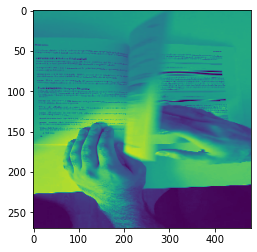

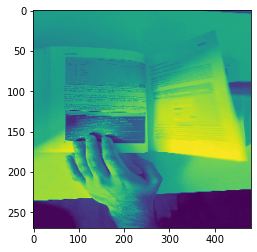

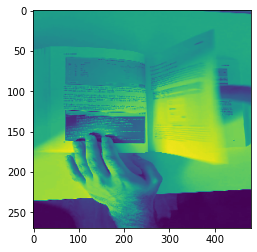

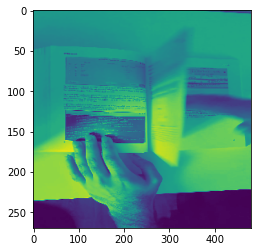

In [16]:
# check a generator
test_generator.reset()
for i in range(4):
    plt.imshow(next(test_generator)[0][0], aspect=IMAGE_HEIGHT/IMAGE_WIDTH)
    plt.show()

### I use convolution and pooling 4 times in succession in my image classification neural net.  

I increased the pool size in the deeper layers in order to keep the number of parameters small (to avoid overfitting). 

In [17]:
# kernel sizes by layer
k_s1 = (3, 3)
k_s2 = (3, 3)
k_s3 = (3, 3)
k_s4 = (3, 3)

# number of kernels per layer
kn1 = 8
kn2 = 16
kn3 = 32
kn4 = 64

# nodes in fully connected layers
nfc = 128

# padding
pad = 'same'

# pooling
pool_size = (2, 2)
deep_pool_size = (4, 4)

# input layer
visible = Input(shape=(IMAGE_WIDTH, IMAGE_HEIGHT, N_CHAN), name='Input')

# hidden layers...

# Convolution and pooling

net = Conv2D(kn1, kernel_size=k_s1, padding=pad, activation='relu', name='C1')(visible)
#              kernel_regularizer=keras.regularizers.l2(l2=0.1), name='C1')(visible)
net = BatchNormalization(name='B1')(net)
net = MaxPool2D(pool_size=pool_size)(net)

net = Conv2D(kn2, kernel_size=k_s2, padding=pad, activation='relu', name='C2')(net)
#              kernel_regularizer=keras.regularizers.l2(l2=0.1), name='C2')(net)
net = BatchNormalization(name='B2')(net)
net = MaxPool2D(pool_size=pool_size)(net)

net = Conv2D(kn3, kernel_size=k_s3, padding=pad, activation='relu', name='C3')(net)
#              kernel_regularizer=keras.regularizers.l2(l2=0.1), name='C3')(net)
net = BatchNormalization(name='B3')(net)
net = MaxPool2D(pool_size=deep_pool_size)(net)

net = Conv2D(kn4, kernel_size=k_s4, padding=pad, activation='relu', name='C4')(net)
#              kernel_regularizer=keras.regularizers.l2(l2=0.1), name='C4')(net)
net = BatchNormalization(name='B4')(net)
net = MaxPool2D(pool_size=deep_pool_size)(net)

# flatten
net = Flatten()(net)

# fully connected...

net = Dense(nfc, activation='relu')(net)
net = BatchNormalization()(net)

net = Dense(nfc, activation='relu')(net)
net = BatchNormalization()(net)

# output layer
net = Dense(1, activation='sigmoid')(net)
simple = Model(inputs=visible, outputs=net, name='Simple')

# summarize layers
print(simple.summary())

Model: "Simple"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Input (InputLayer)           [(None, 270, 480, 1)]     0         
_________________________________________________________________
C1 (Conv2D)                  (None, 270, 480, 8)       80        
_________________________________________________________________
B1 (BatchNormalization)      (None, 270, 480, 8)       32        
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 135, 240, 8)       0         
_________________________________________________________________
C2 (Conv2D)                  (None, 135, 240, 16)      1168      
_________________________________________________________________
B2 (BatchNormalization)      (None, 135, 240, 16)      64        
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 67, 120, 16)       0    

In [18]:
# callbacks and logging

simplelog = 'logs/simple/C8C16C32dPC64dPFD128-deepP4LRpt0001B64E100L2pt1-' + datetime.now().strftime('%Y%m%d-%H%M%S')

simple_tb = keras.callbacks.TensorBoard(log_dir=simplelog, 
                                          histogram_freq=1,
                                          write_graph=False,
                                          write_images=True,
                                          update_freq='epoch')

simple_callbacks = [
#     keras.callbacks.EarlyStopping(min_delta=0.1, patience=3),
    keras.callbacks.ModelCheckpoint(filepath=simplelog + 'saved_models/simple.{epoch:02d}-{val_loss:.2f}.h5'),
    simple_tb]

# anaconda command line
# tensorboard --simplelog logs/simple

In [30]:
simple.compile(optimizer=keras.optimizers.Adam(learning_rate=0.0001), 
               loss=keras.losses.BinaryCrossentropy(), 
               metrics='accuracy')

In [18]:
# CNN parameter
EPOCHS = 100

In [19]:
# batch size
BATCH_SIZE = 64
train_generator.batch_size = BATCH_SIZE
val_generator.batch_size = BATCH_SIZE

In [33]:
simple_story = simple.fit(train_generator, epochs=EPOCHS,
                          steps_per_epoch=len(train_generator.filenames) // BATCH_SIZE,
                          validation_data=val_generator,
                          validation_steps=len(val_generator.filenames) // BATCH_SIZE,
                          callbacks=simple_callbacks).history

Epoch 1/200
30/30 [==============================] - 102s 3s/step - loss: 0.6873 - accuracy: 0.6131 - val_loss: 0.7030 - val_accuracy: 0.4777
Epoch 2/200
30/30 [==============================] - 100s 3s/step - loss: 0.5131 - accuracy: 0.7546 - val_loss: 0.6992 - val_accuracy: 0.4821
Epoch 3/200
30/30 [==============================] - 106s 3s/step - loss: 0.4310 - accuracy: 0.7990 - val_loss: 0.6940 - val_accuracy: 0.4777
Epoch 4/200
30/30 [==============================] - 108s 4s/step - loss: 0.3819 - accuracy: 0.8333 - val_loss: 0.6867 - val_accuracy: 0.5022
Epoch 5/200
30/30 [==============================] - 102s 3s/step - loss: 0.3329 - accuracy: 0.8499 - val_loss: 0.6970 - val_accuracy: 0.5045
Epoch 6/200
30/30 [==============================] - 104s 3s/step - loss: 0.3049 - accuracy: 0.8730 - val_loss: 0.7135 - val_accuracy: 0.5022
Epoch 7/200
30/30 [==============================] - 103s 3s/step - loss: 0.2873 - accuracy: 0.8864 - val_loss: 0.8879 - val_accuracy: 0.4888
Epoch 

30/30 [==============================] - 97s 3s/step - loss: 0.0483 - accuracy: 0.9823 - val_loss: 0.0712 - val_accuracy: 0.9821
Epoch 116/200
30/30 [==============================] - 100s 3s/step - loss: 0.0393 - accuracy: 0.9871 - val_loss: 0.0969 - val_accuracy: 0.9732
Epoch 117/200
30/30 [==============================] - 103s 3s/step - loss: 0.0310 - accuracy: 0.9898 - val_loss: 0.0992 - val_accuracy: 0.9732
Epoch 118/200
30/30 [==============================] - 98s 3s/step - loss: 0.0254 - accuracy: 0.9941 - val_loss: 0.0720 - val_accuracy: 0.9799
Epoch 119/200
30/30 [==============================] - 101s 3s/step - loss: 0.0275 - accuracy: 0.9914 - val_loss: 0.0971 - val_accuracy: 0.9688
Epoch 120/200
30/30 [==============================] - 101s 3s/step - loss: 0.0245 - accuracy: 0.9936 - val_loss: 0.0846 - val_accuracy: 0.9710
Epoch 121/200
30/30 [==============================] - 104s 3s/step - loss: 0.0176 - accuracy: 0.9962 - val_loss: 0.0508 - val_accuracy: 0.9844
Epoch 12

In [22]:
simple_story.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

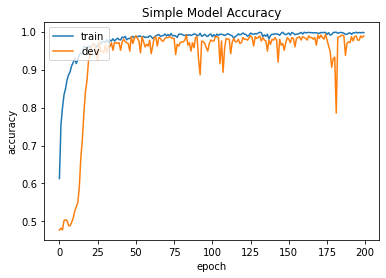

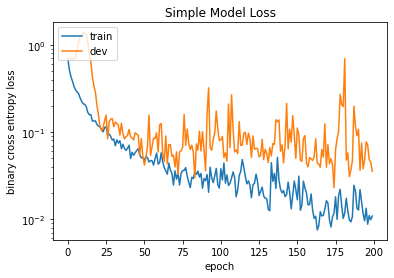

In [34]:
# summarize history for Simple Model

plt.plot(simple_story['accuracy'])
plt.plot(simple_story['val_accuracy'])
plt.title('Simple Model Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'dev'], loc='upper left')
plt.show()

plt.plot(simple_story['loss'])
plt.plot(simple_story['val_loss'])
plt.title('Simple Model Loss')
plt.ylabel('binary cross entropy loss')
plt.yscale('log')
# plt.ylim(0.5, 1)
plt.xlabel('epoch')
plt.legend(['train', 'dev'], loc='upper left')
plt.show()

### From above, we can see that the validation loss levels off around the 70th-75th epoch.

In [35]:
m_acc = simple_story['accuracy']
v_acc = simple_story['val_accuracy']
m_loss = simple_story['loss']
v_loss = simple_story['val_loss']

In [38]:
learning_curves = pd.DataFrame({'accuracy': m_acc, 'val_accuracy': v_acc, 'loss': m_loss, 'val_loss': v_loss})
# learning_curves.to_csv('C8C16C32dPC64dPFD128-deepP4LRpt0001B64E200L2pt1.csv', index=False)
learning_curves.head()

accuracy  val_accuracy      loss  val_loss
0  0.613076      0.477679  0.687285  0.703045
1  0.754555      0.482143  0.513083  0.699179
2  0.799035      0.477679  0.431031  0.694000
3  0.833333      0.502232  0.381871  0.686672
4  0.849946      0.504464  0.332895  0.696978

In [18]:
# reconstructed model (early stop at epoch = 75)
recon_simple_E75 = keras.models.load_model('saved_models/simple.75-0.06.h5')

### Model evaluation

In [19]:
# model predictions 

test_generator.reset()
pred_E75 = recon_simple_E75.predict(test_generator)

In [20]:
df_scores = pd.DataFrame({'Labels': test_generator.classes, 
                          'Predictions_E75': np.around(pred_E75, 3).T[0]})
df_scores.sample(5)

Labels  Predictions_E75
423       1            0.970
44        0            0.000
291       1            0.999
273       0            0.012
87        0            0.001

In [26]:
# for understanding labels
item0 = [i for i in test_generator.class_indices.items()][0]
item1 = [i for i in test_generator.class_indices.items()][1]

In [27]:
# confusion matrix

print('Note:',
      f'{item0[1]} corresponds to {item0[0]} '
      f'and {item1[1]} corresponds to {item1[0]}.')

cm_E75 = pd.crosstab(df_scores.Labels, np.around(df_scores.Predictions_E75, 0), 
                     margins=True, margins_name='Total')
display(cm_E75)

Note: 0 corresponds to flip and 1 corresponds to notflip.


Predictions_E75  0.0  1.0  Total
Labels                          
0                286    4    290
1                 10  297    307
Total            296  301    597

In [28]:
# classification report

print('Note:',
      f'{item0[1]} corresponds to {item0[0]} '
      f'and {item1[1]} corresponds to {item1[0]}.\n')

print('Model with 4 Convolutions/Poolings and 2 Dense Layers at 75 Epochs:\n')
print(classification_report(df_scores.Labels, np.around(df_scores.Predictions_E75, 0)))

Note: 0 corresponds to flip and 1 corresponds to notflip.

Model with 4 Convolutions/Poolings and 2 Dense Layers at 75 Epochs:

              precision    recall  f1-score   support

           0       0.97      0.99      0.98       290
           1       0.99      0.97      0.98       307

    accuracy                           0.98       597
   macro avg       0.98      0.98      0.98       597
weighted avg       0.98      0.98      0.98       597



### F1 score = 98%

In [29]:
pred_E75mask = np.ma.where(pred_E75 >= 0.5, 1, 0).flatten()
# predicted_class_indices = np.where(pred_E75mask)
predicted_class_indices = pred_E75mask
labels = train_generator.class_indices
labels = dict((v, k) for k, v in labels.items())
predictions = [labels[k] for k in predicted_class_indices]
predictions

['flip',
 'flip',
 'flip',
 'flip',
 'flip',
 'flip',
 'flip',
 'flip',
 'flip',
 'flip',
 'flip',
 'flip',
 'flip',
 'flip',
 'flip',
 'flip',
 'flip',
 'flip',
 'flip',
 'flip',
 'flip',
 'flip',
 'flip',
 'flip',
 'flip',
 'flip',
 'flip',
 'flip',
 'flip',
 'flip',
 'flip',
 'flip',
 'flip',
 'flip',
 'flip',
 'flip',
 'flip',
 'flip',
 'flip',
 'flip',
 'flip',
 'flip',
 'flip',
 'flip',
 'flip',
 'flip',
 'flip',
 'flip',
 'flip',
 'flip',
 'flip',
 'flip',
 'flip',
 'flip',
 'flip',
 'flip',
 'flip',
 'flip',
 'flip',
 'flip',
 'flip',
 'flip',
 'flip',
 'flip',
 'flip',
 'flip',
 'flip',
 'flip',
 'flip',
 'flip',
 'flip',
 'flip',
 'flip',
 'flip',
 'flip',
 'flip',
 'flip',
 'flip',
 'flip',
 'flip',
 'flip',
 'flip',
 'flip',
 'flip',
 'flip',
 'flip',
 'flip',
 'flip',
 'flip',
 'flip',
 'flip',
 'flip',
 'flip',
 'flip',
 'flip',
 'flip',
 'flip',
 'flip',
 'flip',
 'flip',
 'flip',
 'flip',
 'flip',
 'flip',
 'flip',
 'flip',
 'flip',
 'flip',
 'flip',
 'flip',
 'flip',
 

### Bonus: Video Classification

I simplified the frame concatenation and sequence labeling process here that makes it easily compatible with the generator approach I used above.  

Instead of combining all the videos by VideoID (in VideoID_FrameNumber), I somewhat randomly combined flipping and not flipping frames in a way that generates 5-frame sequences that always contain a flip. These go into a subdirectories (for train, val, test) called 'sequences/.../hasflip'. The remaining frames from the not flipping group go in a new subdirectory called 'sequences/.../notflip'.

In addition, I set the number of frames in any sequence under consideration as 5.

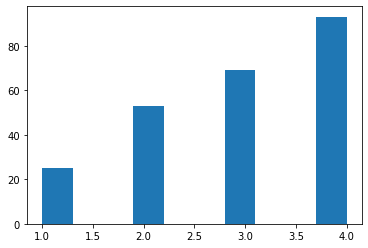

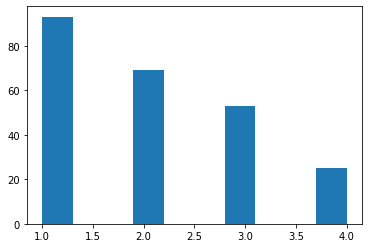

In [75]:
# random integers for psuedo randomly concatenating flip/notflip images
# to build a dataset of sequences that always contain a flip
random_ints = np.random.choice([1, 2, 2, 3, 3, 3, 4, 4, 4, 4], size=240)

# plot random integers
plt.hist(random_ints)
plt.show()
# plot their "complements"
plt.hist(5 - random_ints);

In [76]:
# relevant lists

flip_list_train = [x for x in train_generator.filenames if x[0] == 'f']
notflip_list_train = [x for x in train_generator.filenames if x[0] == 'n']

flip_list_val = [x for x in val_generator.filenames if x[0] == 'f']
notflip_list_val = [x for x in val_generator.filenames if x[0] == 'n']

flip_list_test = [x for x in test_generator.filenames if x[0] == 'f']
notflip_list_test = [x for x in test_generator.filenames if x[0] == 'n']

In [77]:
# create concatenations

# training...

# initialize counters
flip_count = 0
notflip_count = 0
# initialize list
vid_flip_list_train = []

# loop to create lists of 'video' sequences
for r in random_ints:
    # add to lists
    vid_flip_list_train.extend(flip_list_train[flip_count: (flip_count + r)])
    vid_flip_list_train.extend(notflip_list_train[notflip_count: (notflip_count + 5 - r)])
    # update counters
    flip_count += r
    notflip_count += (5 - r)
    
    
# val...

# initialize counters
flip_count = 0
notflip_count = 0
# initialize list
vid_flip_list_val = []

# loop to create lists of 'video' sequences
for r in random_ints[:60]: # less points due to less files
    # add to lists
    vid_flip_list_val.extend(flip_list_val[flip_count: (flip_count + r)])
    vid_flip_list_val.extend(notflip_list_val[notflip_count: (notflip_count + 5 - r)])
    # update counters
    flip_count += r
    notflip_count += (5 - r)
    

# test...

# initialize counters
flip_count = 0
notflip_count = 0
# initialize list
vid_flip_list_test = []

# loop to create lists of 'video' sequences
for r in random_ints[:75]:# less points due to less files
    # add to lists
    vid_flip_list_test.extend(flip_list_test[flip_count: (flip_count + r)])
    vid_flip_list_test.extend(notflip_list_test[notflip_count: (notflip_count + 5 - r)])
    # update counters
    flip_count += r
    notflip_count += (5 - r)

In [85]:
# fyi, here is one of the lists, which always has at least 1 page flip in a 5 frame sequence
vid_flip_list_test

['flip\\0001_000000020.jpg',
 'flip\\0002_000000012.jpg',
 'flip\\0002_000000013.jpg',
 'notflip\\0001_000000002.jpg',
 'notflip\\0001_000000004.jpg',
 'flip\\0002_000000015.jpg',
 'flip\\0002_000000017.jpg',
 'flip\\0003_000000005.jpg',
 'flip\\0003_000000008.jpg',
 'notflip\\0001_000000009.jpg',
 'flip\\0003_000000022.jpg',
 'notflip\\0001_000000014.jpg',
 'notflip\\0001_000000024.jpg',
 'notflip\\0002_000000003.jpg',
 'notflip\\0002_000000006.jpg',
 'flip\\0003_000000025.jpg',
 'flip\\0004_000000006.jpg',
 'flip\\0004_000000013.jpg',
 'flip\\0004_000000014.jpg',
 'notflip\\0002_000000008.jpg',
 'flip\\0004_000000027.jpg',
 'flip\\0005_000000003.jpg',
 'flip\\0005_000000008.jpg',
 'notflip\\0002_000000012.jpg',
 'notflip\\0002_000000015.jpg',
 'flip\\0005_000000018.jpg',
 'flip\\0005_000000023.jpg',
 'flip\\0005_000000028.jpg',
 'flip\\0006_000000001.jpg',
 'notflip\\0002_000000026.jpg',
 'flip\\0006_000000006.jpg',
 'flip\\0006_000000008.jpg',
 'flip\\0006_000000012.jpg',
 'flip\\00

In [113]:
# paths for these videos (sequences)
TRAIN_vDIR = 'sequences/training/'
VAL_vDIR = 'sequences/valid/'
TEST_vDIR = 'sequences/testing/'

In [97]:
# (ONLY RUN THIS CELL ONCE!)

# copy files from lists above into 'hasflip' subdirectory, since these 5-frame sequences 
# will always contain at least 1 frame with a page flip


# # training 'hasflip' files

# for i, file_to_copy in enumerate(vid_flip_list_train):
    
#     # list index used for filename
#     fnum = str(i).zfill(4)
    
#     # source
#     src = TRAIN_DIR + file_to_copy.replace(os.sep, '/')
    
#     # destination (with new filename)
#     dst = TRAIN_vDIR + f'hasflip/{fnum}.jpg'
    
#     # copy newly named file
#     shutil.copyfile(src, dst)


# # val 'hasflip' files

# for i, file_to_copy in enumerate(vid_flip_list_val):
    
#     # list index used for filename
#     fnum = str(i).zfill(4)
    
#     # source
#     src = VAL_DIR + file_to_copy.replace(os.sep, '/')
    
#     # destination (with new filename)
#     dst = VAL_vDIR + f'hasflip/{fnum}.jpg'
    
#     # copy newly named file
#     shutil.copyfile(src, dst)
    

# # test 'hasflip' files

# for i, file_to_copy in enumerate(vid_flip_list_test):
    
#     # list index used for filename
#     fnum = str(i).zfill(4)
    
#     # source
#     src = TEST_DIR + file_to_copy.replace(os.sep, '/')
    
#     # destination (with new filename)
#     dst = TEST_vDIR + f'hasflip/{fnum}.jpg'
    
#     # copy newly named file
#     shutil.copyfile(src, dst)

In [110]:
# (ONLY RUN THIS CELL ONCE!)

# copy remaining files from 'notflip' that are not in the lists above


# # training 'notflip' files

# remaining_train = [x for x in notflip_list_train if x not in vid_flip_list_train]
# for the_file in remaining_train:
    
#     # source
#     src = TRAIN_DIR + the_file.replace(os.sep, '/')
    
#     # destination
#     dst = TRAIN_vDIR + the_file.replace(os.sep, '/')
    
#     # copy file
#     shutil.copyfile(src, dst)


# # val 'notflip' files

# remaining_val = [x for x in notflip_list_val if x not in vid_flip_list_val]
# for the_file in remaining_val:
    
#     # source
#     src = VAL_DIR + the_file.replace(os.sep, '/')
    
#     # destination
#     dst = VAL_vDIR + the_file.replace(os.sep, '/')
    
#     # copy file
#     shutil.copyfile(src, dst)
    

# # test 'notflip' files

# remaining_test = [x for x in notflip_list_test if x not in vid_flip_list_test]
# for the_file in remaining_test:
    
#     # source
#     src = TEST_DIR + the_file.replace(os.sep, '/')
    
#     # destination
#     dst = TEST_vDIR + the_file.replace(os.sep, '/')
    
#     # copy file
#     shutil.copyfile(src, dst)

In [111]:
# video version of keras image generator that can provide sequences to the neural net

# https://medium.com/analytics-vidhya/extending-kerass-imagedatagenerator-for-timedistributed-layer-3d5008fe10df

from keras.preprocessing.image import array_to_img, img_to_array, load_img
from keras.preprocessing.image import DirectoryIterator,DataFrameIterator

class TimeDistributedImageDataGenerator(ImageDataGenerator):
    def __init__(self,
                 featurewise_center=False,
                 samplewise_center=False,
                 featurewise_std_normalization=False,
                 samplewise_std_normalization=False,
                 zca_whitening=False,
                 zca_epsilon=1e-6,
                 rotation_range=0,
                 width_shift_range=0.,
                 height_shift_range=0.,
                 brightness_range=None,
                 shear_range=0.,
                 zoom_range=0.,
                 channel_shift_range=0.,
                 fill_mode='nearest',
                 cval=0.,
                 horizontal_flip=False,
                 vertical_flip=False,
                 rescale=None,
                 preprocessing_function=None,
                 data_format=None,
                 validation_split=0.0,
                 dtype=None,
                 time_steps=5):

                 self.time_steps = time_steps

                 super().__init__(featurewise_center=featurewise_center,
                                  samplewise_center=samplewise_center,
                                  featurewise_std_normalization=featurewise_std_normalization,
                                  samplewise_std_normalization=samplewise_std_normalization,
                                  zca_whitening=zca_whitening,
                                  zca_epsilon=zca_epsilon,
                                  rotation_range=rotation_range,
                                  width_shift_range=width_shift_range,
                                  height_shift_range=height_shift_range,
                                  brightness_range=brightness_range,
                                  shear_range=shear_range,
                                  zoom_range=zoom_range,
                                  channel_shift_range=channel_shift_range,
                                  fill_mode=fill_mode,
                                  cval=cval,
                                  horizontal_flip=horizontal_flip,
                                  vertical_flip=vertical_flip,
                                  rescale=rescale,
                                  preprocessing_function=preprocessing_function,
                                  data_format=data_format,
                                  validation_split=validation_split,
                                  dtype = dtype)

    def flow_from_directory(self,
                            directory,
                            target_size=(256, 256),
                            color_mode='rgb',
                            classes=None,
                            class_mode='categorical',
                            batch_size=32,
                            shuffle=True,
                            seed=None,
                            save_to_dir=None,
                            save_prefix='',
                            save_format='png',
                            follow_links=False,
                            subset=None,
                            interpolation='nearest'):

                            return TimeDistributedDirectoryIterator(
                            directory,
                            self,
                            target_size=target_size,
                            color_mode=color_mode,
                            classes=classes,
                            class_mode=class_mode,
                            data_format=self.data_format,
                            batch_size=batch_size,
                            shuffle=shuffle,
                            seed=seed,
                            save_to_dir=save_to_dir,
                            save_prefix=save_prefix,
                            save_format=save_format,
                            follow_links=follow_links,
                            subset=subset,
                            interpolation=interpolation
                            )

    def flow_from_dataframe(self,
                            dataframe,
                            directory=None,
                            x_col="filename",
                            y_col="class",
                            weight_col=None,
                            target_size=(256, 256),
                            color_mode='rgb',
                            classes=None,
                            class_mode='categorical',
                            batch_size=32,
                            shuffle=True,
                            seed=None,
                            save_to_dir=None,
                            save_prefix='',
                            save_format='png',
                            subset=None,
                            interpolation='nearest',
                            validate_filenames=True,
                            **kwargs):
                            
                            return TimeDistributedDataFrameIterator(
                            dataframe,
                            directory,
                            self,
                            x_col=x_col,
                            y_col=y_col,
                            weight_col=weight_col,
                            target_size=target_size,
                            color_mode=color_mode,
                            classes=classes,
                            class_mode=class_mode,
                            data_format=self.data_format,
                            batch_size=batch_size,
                            shuffle=shuffle,
                            seed=seed,
                            save_to_dir=save_to_dir,
                            save_prefix=save_prefix,
                            save_format=save_format,
                            subset=subset,
                            interpolation=interpolation,
                            validate_filenames=validate_filenames,
                            **kwargs
                            )
        
class TimeDistributedDataFrameIterator(DataFrameIterator):

    def _get_batches_of_transformed_samples(self, index_array):

        TimeSteps = self.image_data_generator.time_steps
        batch_x = np.zeros((len(index_array),) + (TimeSteps,) + self.image_shape, dtype=self.dtype)#KJ
        # build batch of image data
        # self.filepaths is dynamic, is better to call it once outside the loop
        filepaths = self.filepaths
        for i, j in enumerate(index_array):
            for k in reversed(range(0,TimeSteps)):
                try:
                    img = load_img(filepaths[j-k],
                                color_mode=self.color_mode,
                                target_size=self.target_size,
                                interpolation=self.interpolation)
                    x = img_to_array(img, data_format=self.data_format)
                except:
                    pass
                # Pillow images should be closed after `load_img`,
                # but not PIL images.
                if hasattr(img, 'close'):
                    img.close()
                if self.image_data_generator:
                    params = self.image_data_generator.get_random_transform(x.shape)
                    x = self.image_data_generator.apply_transform(x, params)
                    x = self.image_data_generator.standardize(x)
                batch_x[i][k] = x
        # optionally save augmented images to disk for debugging purposes
        if self.save_to_dir:
            for i, j in enumerate(index_array):
                img = array_to_img(batch_x[i], self.data_format, scale=True)
                fname = '{prefix}_{index}_{hash}.{format}'.format(
                    prefix=self.save_prefix,
                    index=j,
                    hash=np.random.randint(1e7),
                    format=self.save_format)
                img.save(os.path.join(self.save_to_dir, fname))
        # build batch of labels
        if self.class_mode == 'input':
            batch_y = batch_x.copy()
        elif self.class_mode in {'binary', 'sparse'}:
            batch_y = np.empty(len(batch_x), dtype=self.dtype)
            for i, n_observation in enumerate(index_array):
                batch_y[i] = self.classes[n_observation]
        elif self.class_mode == 'categorical':
            batch_y = np.zeros((len(batch_x), TimeSteps, len(self.class_indices)),
                               dtype=self.dtype)
            for i, n_observation in enumerate(index_array):
                for q in reversed(range(0,TimeSteps)):
                    batch_y[i,q,self.classes[n_observation-q]] = 1.
        elif self.class_mode == 'multi_output':
            batch_y = [output[index_array] for output in self.labels]
        elif self.class_mode == 'raw':
            batch_y = self.labels[index_array]
        else:
            return batch_x
        if self.sample_weight is None:
            return batch_x, batch_y
        else:
            return batch_x, batch_y, self.sample_weight[index_array]

class TimeDistributedDirectoryIterator(DirectoryIterator):

    def _get_batches_of_transformed_samples(self, index_array):

        TimeSteps = self.image_data_generator.time_steps
        batch_x = np.zeros((len(index_array),) + (TimeSteps,) + self.image_shape, dtype=self.dtype)#KJ
        # build batch of image data
        # self.filepaths is dynamic, is better to call it once outside the loop
        filepaths = self.filepaths
        for i, j in enumerate(index_array):
            for k in reversed(range(0,TimeSteps)):
                try:
                    img = load_img(filepaths[j-k],
                                color_mode=self.color_mode,
                                target_size=self.target_size,
                                interpolation=self.interpolation)
                    x = img_to_array(img, data_format=self.data_format)
                except:
                    pass
                # Pillow images should be closed after `load_img`,
                # but not PIL images.
                if hasattr(img, 'close'):
                    img.close()
                if self.image_data_generator:
                    params = self.image_data_generator.get_random_transform(x.shape)
                    x = self.image_data_generator.apply_transform(x, params)
                    x = self.image_data_generator.standardize(x)
                batch_x[i][k] = x
        # optionally save augmented images to disk for debugging purposes
        if self.save_to_dir:
            for i, j in enumerate(index_array):
                img = array_to_img(batch_x[i], self.data_format, scale=True)
                fname = '{prefix}_{index}_{hash}.{format}'.format(
                    prefix=self.save_prefix,
                    index=j,
                    hash=np.random.randint(1e7),
                    format=self.save_format)
                img.save(os.path.join(self.save_to_dir, fname))
        # build batch of labels
        if self.class_mode == 'input':
            batch_y = batch_x.copy()
        elif self.class_mode in {'binary', 'sparse'}:
            batch_y = np.empty(len(batch_x), dtype=self.dtype)
            for i, n_observation in enumerate(index_array):
                batch_y[i] = self.classes[n_observation]
        elif self.class_mode == 'categorical':
            batch_y = np.zeros((len(batch_x), TimeSteps, len(self.class_indices)),
                               dtype=self.dtype)
            for i, n_observation in enumerate(index_array):
                for q in reversed(range(0,TimeSteps)):
                    batch_y[i,q,self.classes[n_observation-q]] = 1.
        elif self.class_mode == 'multi_output':
            batch_y = [output[index_array] for output in self.labels]
        elif self.class_mode == 'raw':
            batch_y = self.labels[index_array]
        else:
            return batch_x
        if self.sample_weight is None:
            return batch_x, batch_y
        else:
            return batch_x, batch_y, self.sample_weight[index_array]

In [114]:
# model architecture similar to our image classifier, but handling sequences, and including a GRU prior to the output

# number of frames in sequence
nf = 5

# kernel sizes by layer
k_s1 = (3, 3)
k_s2 = (3, 3)
k_s3 = (3, 3)

# number of kernels per layer
kn1 = 8
kn2 = 16
kn3 = 32

# nodes in fully connected layers
nfc = 64

# padding
pad = 'same'

# pooling
pool_size = (2, 2)
deep_pool_size = (4, 4)

# number of nodes in GRU
ngru = 64

# input layer
visible = Input(shape=(nf, IMAGE_WIDTH // 2, IMAGE_HEIGHT // 2, N_CHAN), name='Input')

# hidden layers...

# Convolution and pooling (no batch normalization, since this leads to a problem within TimeDistributed)

net = TimeDistributed(Conv2D(kn1, kernel_size=k_s1, padding=pad, activation='relu', name='C1'), name='tdC1')(visible)
net = TimeDistributed(MaxPool2D(pool_size=pool_size), name='tdMP1')(net)

net = TimeDistributed(Conv2D(kn2, kernel_size=k_s2, padding=pad, activation='relu', name='C2'), name='tdC2')(net)
net = TimeDistributed(MaxPool2D(pool_size=deep_pool_size), name='tdMP2')(net)

net = TimeDistributed(Conv2D(kn3, kernel_size=k_s3, padding=pad, activation='relu', name='C3'), name='tdC3')(net)
net = TimeDistributed(MaxPool2D(pool_size=deep_pool_size), name='tdMP3')(net)

# flatten
net = TimeDistributed(Flatten(), name='tdF')(net)

# fully connected...

net = TimeDistributed(Dense(nfc, activation='relu'), name='tdD1')(net)
net = TimeDistributed(Dropout(0.4), name='tdDr1')(net)
net = TimeDistributed(Dense(nfc, activation='relu'), name='tdD2')(net)
net = TimeDistributed(Dropout(0.4), name='tdDr2')(net)

# GRU on sequence
net = GRU(ngru, name='GRU')(net)
net = Dropout(0.4, name='Dr')(net)

# output layer
net = Dense(1, activation='sigmoid')(net)
bonus = Model(inputs=visible, outputs=net, name='Bonus')

# summarize layers
print(bonus.summary())

Model: "Bonus"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Input (InputLayer)           [(None, 5, 135, 240, 1)]  0         
_________________________________________________________________
tdC1 (TimeDistributed)       (None, 5, 135, 240, 8)    80        
_________________________________________________________________
tdMP1 (TimeDistributed)      (None, 5, 67, 120, 8)     0         
_________________________________________________________________
tdC2 (TimeDistributed)       (None, 5, 67, 120, 16)    1168      
_________________________________________________________________
tdMP2 (TimeDistributed)      (None, 5, 16, 30, 16)     0         
_________________________________________________________________
tdC3 (TimeDistributed)       (None, 5, 16, 30, 32)     4640      
_________________________________________________________________
tdMP3 (TimeDistributed)      (None, 5, 4, 7, 32)       0     

In [115]:
# generators for training set of 5-frame sequences

train_dataseq_generator = TimeDistributedImageDataGenerator(
    rescale=1./255,
    zoom_range=0.1,
    horizontal_flip=True, 
    vertical_flip=True,
    time_steps=5) # always using 5-frame sequences, which is a limitation for our approach

train_video_gen = train_dataseq_generator.flow_from_directory(
    TRAIN_vDIR,
    target_size=(IMAGE_WIDTH // 2, IMAGE_HEIGHT // 2), # reduce for computation time
    color_mode='grayscale',
    class_mode='binary',
    seed=ranseed,
    shuffle=False) # no shuffling because we need to ensure there is a 'flip' in all 5 frame sequences

Found 1700 images belonging to 2 classes.


In [116]:
val_dataseq_generator = TimeDistributedImageDataGenerator(rescale=1./255, time_steps=5) # always using 
# 5-frame sequences, which is a limitation for our approach

val_video_gen = val_dataseq_generator.flow_from_directory(
    VAL_vDIR,
    target_size=(IMAGE_WIDTH // 2, IMAGE_HEIGHT // 2), # reduce for computation time
    color_mode='grayscale',
    class_mode='binary',
    seed=ranseed,
    shuffle=False) # no shuffling because we need to ensure there is a 'flip' in all 5 frame sequences

Found 417 images belonging to 2 classes.


In [117]:
test_dataseq_generator = TimeDistributedImageDataGenerator(rescale=1./255, time_steps=5) # always using 
# 5-frame sequences, which is a limitation for our approach

test_video_gen = test_dataseq_generator.flow_from_directory(
    TEST_vDIR,
    target_size=(IMAGE_WIDTH // 2, IMAGE_HEIGHT // 2), # reduce for computation time
    color_mode='grayscale',
    class_mode='binary',
    batch_size=1,
    shuffle=False)

Found 533 images belonging to 2 classes.


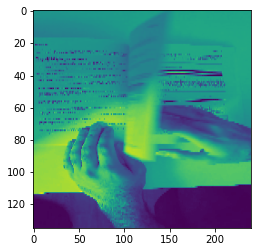

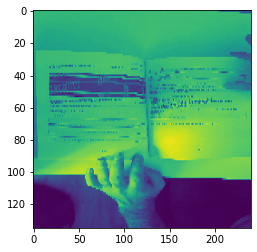

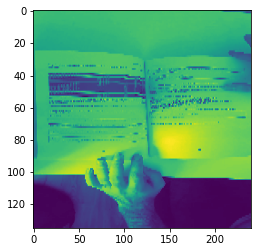

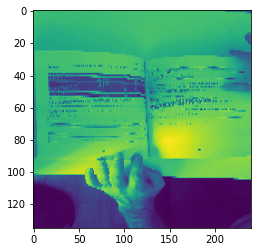

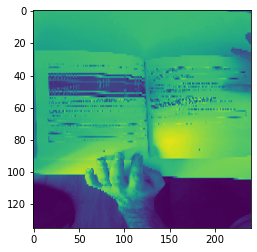

In [118]:
# check the test video generator

test_video_gen.reset()
vid = next(test_video_gen)[0][0]
for i in range(5):
    plt.imshow(vid[i], aspect=IMAGE_HEIGHT/IMAGE_WIDTH)
    plt.show()

In [137]:
# callbacks and logging

bonuslog = 'logs/bonus/C8C16dPC32dPFD64Drpt4Gr64Drpt4-deepP4LRpt0001B64E150-' + datetime.now().strftime('%Y%m%d-%H%M%S')

bonus_tb = keras.callbacks.TensorBoard(log_dir=bonuslog, 
                                          histogram_freq=1,
                                          write_graph=False,
                                          write_images=True,
                                          update_freq='epoch')

bonus_callbacks = [
#     keras.callbacks.EarlyStopping(min_delta=0.1, patience=3),
    keras.callbacks.ModelCheckpoint(filepath=bonuslog + 'saved_models/bonus.{epoch:02d}-{val_loss:.2f}.h5'),
    bonus_tb]


# anaconda command line
# tensorboard --bonuslog logs/bonus

In [138]:
bonus.compile(optimizer=keras.optimizers.Adam(learning_rate=0.0001), 
               loss=keras.losses.BinaryCrossentropy(), 
               metrics='accuracy')

In [139]:
# CNN parameter
EPOCHS = 150

In [140]:
# batch size
BATCH_SIZE = 64
train_video_gen.batch_size = BATCH_SIZE
val_video_gen.batch_size = BATCH_SIZE

In [141]:
bonus_story = bonus.fit(train_video_gen, epochs=EPOCHS,
                          steps_per_epoch=len(train_video_gen.filenames) // BATCH_SIZE,
                          validation_data=val_video_gen,
                          validation_steps=len(val_video_gen.filenames) // BATCH_SIZE,
                          callbacks=bonus_callbacks).history

Epoch 1/150
26/26 [==============================] - 399s 15s/step - loss: 0.5854 - accuracy: 0.7335 - val_loss: 0.5328 - val_accuracy: 0.7812
Epoch 2/150
26/26 [==============================] - 391s 15s/step - loss: 0.5917 - accuracy: 0.7335 - val_loss: 0.5237 - val_accuracy: 0.7812
Epoch 3/150
26/26 [==============================] - 404s 16s/step - loss: 0.6089 - accuracy: 0.6944 - val_loss: 0.5351 - val_accuracy: 0.7812
Epoch 4/150
26/26 [==============================] - 387s 15s/step - loss: 0.6088 - accuracy: 0.6944 - val_loss: 0.5411 - val_accuracy: 0.7812
Epoch 5/150
26/26 [==============================] - 396s 15s/step - loss: 0.5837 - accuracy: 0.7212 - val_loss: 0.5383 - val_accuracy: 0.7812
Epoch 6/150
26/26 [==============================] - 398s 15s/step - loss: 0.6003 - accuracy: 0.6944 - val_loss: 0.5305 - val_accuracy: 0.7812
Epoch 7/150
26/26 [==============================] - 395s 15s/step - loss: 0.5942 - accuracy: 0.6944 - val_loss: 0.5203 - val_accuracy: 0.7812

Epoch 58/150
26/26 [==============================] - 374s 14s/step - loss: 0.2663 - accuracy: 0.9095 - val_loss: 0.3212 - val_accuracy: 0.8516
Epoch 59/150
26/26 [==============================] - 379s 15s/step - loss: 0.2288 - accuracy: 0.9334 - val_loss: 0.3401 - val_accuracy: 0.8620
Epoch 60/150
26/26 [==============================] - 372s 14s/step - loss: 0.2936 - accuracy: 0.9028 - val_loss: 0.3438 - val_accuracy: 0.8490
Epoch 61/150
26/26 [==============================] - 372s 15s/step - loss: 0.2536 - accuracy: 0.9169 - val_loss: 0.3269 - val_accuracy: 0.8542
Epoch 62/150
26/26 [==============================] - 375s 15s/step - loss: 0.2589 - accuracy: 0.9169 - val_loss: 0.3116 - val_accuracy: 0.8542
Epoch 63/150
26/26 [==============================] - 375s 14s/step - loss: 0.2573 - accuracy: 0.9187 - val_loss: 0.3171 - val_accuracy: 0.8516
Epoch 64/150
26/26 [==============================] - 372s 14s/step - loss: 0.2973 - accuracy: 0.8881 - val_loss: 0.3172 - val_accuracy:

Epoch 115/150
26/26 [==============================] - 363s 14s/step - loss: 0.1638 - accuracy: 0.9358 - val_loss: 0.1924 - val_accuracy: 0.9219
Epoch 116/150
26/26 [==============================] - 361s 14s/step - loss: 0.1711 - accuracy: 0.9315 - val_loss: 0.2076 - val_accuracy: 0.9115
Epoch 117/150
26/26 [==============================] - 363s 14s/step - loss: 0.1785 - accuracy: 0.9205 - val_loss: 0.2195 - val_accuracy: 0.8672
Epoch 118/150
26/26 [==============================] - 370s 14s/step - loss: 0.2055 - accuracy: 0.9175 - val_loss: 0.1942 - val_accuracy: 0.9141
Epoch 119/150
26/26 [==============================] - 362s 14s/step - loss: 0.1700 - accuracy: 0.9328 - val_loss: 0.2016 - val_accuracy: 0.9167
Epoch 120/150
26/26 [==============================] - 365s 14s/step - loss: 0.1600 - accuracy: 0.9273 - val_loss: 0.1894 - val_accuracy: 0.9219
Epoch 121/150
26/26 [==============================] - 360s 14s/step - loss: 0.1600 - accuracy: 0.9358 - val_loss: 0.2096 - val_ac

In [142]:
bonus_story.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

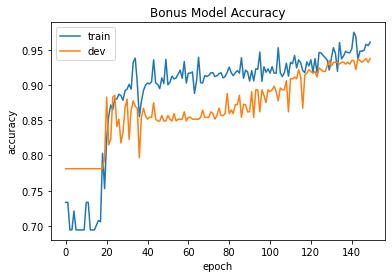

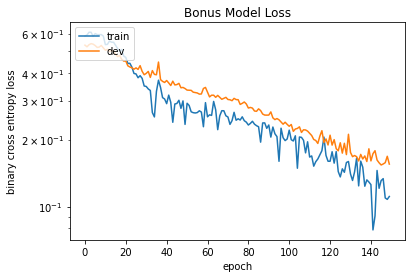

In [143]:
# summarize history for Bonus Model (dropout = 0.4 for Dense and GRU)

plt.plot(bonus_story['accuracy'])
plt.plot(bonus_story['val_accuracy'])
plt.title('Bonus Model Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'dev'], loc='upper left')
plt.show()

plt.plot(bonus_story['loss'])
plt.plot(bonus_story['val_loss'])
plt.title('Bonus Model Loss')
plt.ylabel('binary cross entropy loss')
plt.yscale('log')
# plt.ylim(0.5, 1)
plt.xlabel('epoch')
plt.legend(['train', 'dev'], loc='upper left')
plt.show()

In [144]:
m_acc_bonus = bonus_story['accuracy']
v_acc_bonus = bonus_story['val_accuracy']
m_loss_bonus = bonus_story['loss']
v_loss_bonus = bonus_story['val_loss']

In [145]:
learning_curves_bonus = pd.DataFrame({'accuracy': m_acc_bonus, 'val_accuracy': v_acc_bonus, 
                                      'loss': m_loss_bonus, 'val_loss': v_loss_bonus})
learning_curves_bonus.to_csv('C8C16dPC32dPFD64Drpt4Gr64Drpt4-deepP4LRpt0001B64E150.csv', index=False)
learning_curves_bonus.head()

accuracy  val_accuracy      loss  val_loss
0  0.733496       0.78125  0.585394  0.532778
1  0.733496       0.78125  0.591696  0.523670
2  0.694377       0.78125  0.608911  0.535124
3  0.694377       0.78125  0.608818  0.541052
4  0.721154       0.78125  0.583700  0.538251

In [146]:
# reconstructed model (early stop at epoch = 130)
recon_bonus_E130 = keras.models.load_model(
    'logs/bonus/C8C16dPC32dPFD64Drpt4Gr64Drpt4-deepP4LRpt0001B64E150-20220526-134919saved_models/bonus.130-0.21.h5')

### Bonus model evaluation

In [147]:
# model predictions 

test_video_gen.reset()
bonus_pred_E150 = bonus.predict(test_video_gen)
test_video_gen.reset()
bonus_pred_E130 = recon_bonus_E130.predict(test_video_gen)

In [149]:
df_scores_bonus = pd.DataFrame({'Labels': test_video_gen.classes, 
                          'Predictions_E150': np.around(bonus_pred_E150, 3).T[0]})
print('end of 150 epochs:')
display(df_scores_bonus.sample(5))

df_scores_bonus_early = pd.DataFrame({'Labels': test_video_gen.classes, 
                          'Predictions_E130': np.around(bonus_pred_E130, 3).T[0]})
print('after 130 epochs:')
df_scores_bonus_early.sample(5)

end of 150 epochs:


Labels  Predictions_E150
183       0             0.001
389       1             0.816
162       0             0.001
174       0             0.001
31        0             0.001

after 130 epochs:


Labels  Predictions_E130
427       1             0.871
404       1             0.872
296       0             0.036
22        0             0.024
444       1             0.971

In [150]:
# for understanding labels
item0bonus = [i for i in test_video_gen.class_indices.items()][0]
item1bonus = [i for i in test_video_gen.class_indices.items()][1]

In [151]:
# confusion matrix

print('Note:',
      f'{item0bonus[1]} corresponds to {item0bonus[0]} '
      f'and {item1bonus[1]} corresponds to {item1bonus[0]}.')

cm_E150 = pd.crosstab(df_scores_bonus.Labels, np.around(df_scores_bonus.Predictions_E150, 0), 
                     margins=True, margins_name='Total')
display(cm_E150)

Note: 0 corresponds to hasflip and 1 corresponds to notflip.


Predictions_E150  0.0  1.0  Total
Labels                           
0                 363   12    375
1                  24  134    158
Total             387  146    533

In [152]:
# confusion matrix (early stopping)

print('Note:',
      f'{item0bonus[1]} corresponds to {item0bonus[0]} '
      f'and {item1bonus[1]} corresponds to {item1bonus[0]}.')

cm_E130 = pd.crosstab(df_scores_bonus_early.Labels, np.around(df_scores_bonus_early.Predictions_E130, 0), 
                     margins=True, margins_name='Total')
display(cm_E130)

Note: 0 corresponds to hasflip and 1 corresponds to notflip.


Predictions_E130  0.0  1.0  Total
Labels                           
0                 336   39    375
1                  10  148    158
Total             346  187    533

In [153]:
# classification report

print('Note:',
      f'{item0bonus[1]} corresponds to {item0bonus[0]} '
      f'and {item1bonus[1]} corresponds to {item1bonus[0]}.\n')

print('Model with 3 Time Distributed Convolutions/Poolings, 2 Time Distributed Dense Layers, and a GRU at 150 Epochs:\n')
print(classification_report(df_scores_bonus.Labels, np.around(df_scores_bonus.Predictions_E150, 0)))

Note: 0 corresponds to hasflip and 1 corresponds to notflip.

Model with 3 Time Distributed Convolutions/Poolings, 2 Time Distributed Dense Layers, and a GRU at 150 Epochs:

              precision    recall  f1-score   support

           0       0.94      0.97      0.95       375
           1       0.92      0.85      0.88       158

    accuracy                           0.93       533
   macro avg       0.93      0.91      0.92       533
weighted avg       0.93      0.93      0.93       533



In [154]:
# classification report (early stopping)

print('Note:',
      f'{item0bonus[1]} corresponds to {item0bonus[0]} '
      f'and {item1bonus[1]} corresponds to {item1bonus[0]}.\n')

print('Model with 3 Time Distributed Convolutions/Poolings, 2 Time Distributed Dense Layers, and a GRU at 130 Epochs:\n')
print(classification_report(df_scores_bonus_early.Labels, np.around(df_scores_bonus_early.Predictions_E130, 0)))

Note: 0 corresponds to hasflip and 1 corresponds to notflip.

Model with 3 Time Distributed Convolutions/Poolings, 2 Time Distributed Dense Layers, and a GRU at 130 Epochs:

              precision    recall  f1-score   support

           0       0.97      0.90      0.93       375
           1       0.79      0.94      0.86       158

    accuracy                           0.91       533
   macro avg       0.88      0.92      0.90       533
weighted avg       0.92      0.91      0.91       533



### F1 score = 90%

## Conclusions

We built a simple image classifier that almost perfectly (f1 = 98%) distinguishes between page flips and the lack thereof.

In addition, we built a video (5-frame sequence) classifier that distinguishes between videos with the 2 different actions, flipping and not flipping.